In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import matplotlib.ticker as ticker
import swifter
import nltk
import os
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

#NLTK downloads
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import warnings
warnings.filterwarnings('ignore')
# Set the working directory
os.chdir(r'D:\Masters\Fall 2023\CSC 869 Data Mining\Term Project\data\raw')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\thano\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\thano\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\thano\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# Common Functions
def extract_keyword_names(keyword_list):
    if isinstance(keyword_list, list):  # Check if input is a list
        return ' '.join([k['name'].replace(' ', '_') for k in keyword_list if 'name' in k])
    else:
        return ''
    
def get_director(crew):
    for member in crew:
        if member['job'] == 'Director':
            return member['name']
    return None

def get_main_actors(cast, num_actors=3):
    if len(cast) < num_actors:
        num_actors = len(cast)
    return [actor['name'] for actor in cast[:num_actors]]

def literal_eval_col(df, col):
    df[col] = df[col].fillna('[]').map(ast.literal_eval)
    return df

def join_list_elements(lst):
    return ' '.join([str(item) for item in lst]) if isinstance(lst, list) else ''

# Function to convert string of lists/dicts to actual list/dict
def parse_literal_string(literal_string):
    try:
        return ast.literal_eval(literal_string)
    except Exception:
        return []
    
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
def preprocess_overview(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.lower() not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)



In [4]:
#Data-Loading
keywords = pd.read_csv('keywords.csv')
links= pd.read_csv('links.csv')
movies_metadata = pd.read_csv('movies_metadata.csv', low_memory=False)
credits = pd.read_csv('credits.csv')
# replace ratings with ratings_small to avoid memory error , original full file is ratings.csv, to run full file make sure you have atleast 32GB RAM resources
ratings = pd.read_csv('ratings.csv')

datasets = {
    "Keywords": keywords.head(),
    "Links": links.head(),
    "Movies Metadata": movies_metadata.head(),
    "Credits": credits.head(),
    "Ratings": ratings.head()
}

datasets

{'Keywords':       id                                           keywords
 0    862  [{'id': 931, 'name': 'jealousy'}, {'id': 4290,...
 1   8844  [{'id': 10090, 'name': 'board game'}, {'id': 1...
 2  15602  [{'id': 1495, 'name': 'fishing'}, {'id': 12392...
 3  31357  [{'id': 818, 'name': 'based on novel'}, {'id':...
 4  11862  [{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...,
 'Links':    movieId  imdbId   tmdbId
 0        1  114709    862.0
 1        2  113497   8844.0
 2        3  113228  15602.0
 3        4  114885  31357.0
 4        5  113041  11862.0,
 'Movies Metadata':    adult                              belongs_to_collection    budget  \
 0  False  {'id': 10194, 'name': 'Toy Story Collection', ...  30000000   
 1  False                                                NaN  65000000   
 2  False  {'id': 119050, 'name': 'Grumpy Old Men Collect...         0   
 3  False                                                NaN  16000000   
 4  False  {'id': 96871, 'name': 'Father of the 

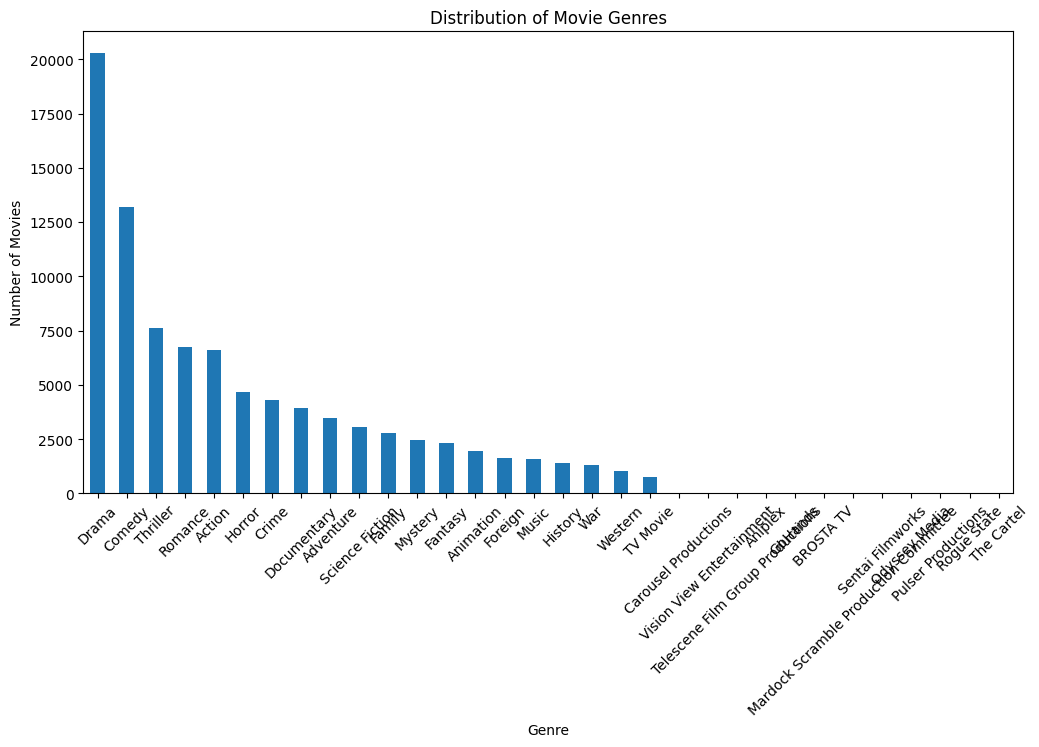

In [5]:

movies_metadata_df=movies_metadata.copy()
ratings_df=ratings.copy()
links_df=links.copy()

# Preprocess movies_metadata_df for visualizations
movies_metadata_df['genres'] = movies_metadata_df['genres'].apply(parse_literal_string)
movies_metadata_df['release_date'] = pd.to_datetime(movies_metadata_df['release_date'], errors='coerce')
movies_metadata_df['year'] = movies_metadata_df['release_date'].dt.year
movies_metadata_df['budget'] = pd.to_numeric(movies_metadata_df['budget'], errors='coerce')
movies_metadata_df['id'] = pd.to_numeric(movies_metadata_df['id'], errors='coerce').astype('Int64')

# Filtering out movies with zero or undefined budget and revenue
valid_budget_revenue_df = movies_metadata_df[(movies_metadata_df['budget'] > 0) & (movies_metadata_df['revenue'] > 0)]

# ratings_df DataFrame - Aligning movie IDs
ratings_df['movieId'] = ratings_df['movieId'].astype(int)
links_df = links_df.dropna(subset=['tmdbId'])
links_df['tmdbId'] = links_df['tmdbId'].astype(int)
movieId_to_tmdbId = dict(zip(links_df['movieId'], links_df['tmdbId']))
ratings_df['tmdbId'] = ratings_df['movieId'].map(movieId_to_tmdbId)
ratings_df['tmdbId'] = ratings_df['tmdbId'].astype('Int64')

# Calculate average ratings_df and join with movies metadata
min_ratings_df_threshold = 50
average_ratings_df = ratings_df.groupby('tmdbId').rating.agg(['mean', 'count'])
popular_movies = average_ratings_df[average_ratings_df['count'] > min_ratings_df_threshold]
top_rated_movies = popular_movies.sort_values(by='mean', ascending=False).head(20)
top_rated_movies_with_titles = top_rated_movies.join(movies_metadata_df.set_index('id')['title'], on='tmdbId')

# High-budget movies analysis
high_budget_threshold = valid_budget_revenue_df['budget'].quantile(0.80)
high_budget_movies = valid_budget_revenue_df[valid_budget_revenue_df['budget'] >= high_budget_threshold]
high_budget_movie_ids = high_budget_movies['id']
high_budget_ratings_df = ratings_df[ratings_df['tmdbId'].isin(high_budget_movie_ids)]
average_rating_high_budget = high_budget_ratings_df.groupby('tmdbId').rating.mean()
overall_average_rating = ratings_df.groupby('tmdbId').rating.mean()

# Visualization Functions
def plot_genre_distribution(movies_metadata_df):
    genre_list = [genre['name'] for movie_genres in movies_metadata_df['genres'] for genre in movie_genres]
    genre_count = pd.Series(genre_list).value_counts()
    plt.figure(figsize=(12, 6))
    genre_count.plot(kind='bar')
    plt.title('Distribution of Movie Genres')
    plt.xlabel('Genre')
    plt.ylabel('Number of Movies')
    plt.xticks(rotation=45)
    plt.show()

def plot_ratings_df_distribution(ratings_df):
    plt.figure(figsize=(10, 6))
    sns.histplot(ratings_df['rating'], kde=True, bins=10)
    plt.title('Distribution of Movie ratings_df')
    plt.xlabel('Rating')
    plt.ylabel('Frequency')
    plt.show()

def plot_movies_per_year(movies_metadata_df):
    plt.figure(figsize=(12, 6))
    movies_per_year = movies_metadata_df['year'].value_counts().sort_index()
    movies_per_year.plot(kind='line')
    plt.title('Number of Movies Released Per Year')
    plt.xlabel('Year')
    plt.ylabel('Number of Movies')
    plt.xlim([movies_per_year.index.min(), movies_per_year.index.max()])
    plt.show()

def plot_budget_vs_revenue(valid_budget_revenue_df):
    plt.figure(figsize=(10, 6))
    plt.scatter(valid_budget_revenue_df['budget'], valid_budget_revenue_df['revenue'], alpha=0.5)
    plt.title('Movie Budget vs Revenue')
    plt.xlabel('Budget')
    plt.ylabel('Revenue')
    plt.xscale('log')
    plt.yscale('log')
    plt.show()

def plot_high_budget_genre_distribution(high_budget_movies):
    high_budget_genres = [genre['name'] for movie_genres in high_budget_movies['genres'] for genre in movie_genres]
    high_budget_genre_count = pd.Series(high_budget_genres).value_counts()
    plt.figure(figsize=(12, 6))
    high_budget_genre_count.plot(kind='bar')
    plt.title('Distribution of Genres in High-Budget Movies')
    plt.xlabel('Genre')
    plt.ylabel('Number of High-Budget Movies')
    plt.xticks(rotation=45)
    plt.show()

def plot_high_budget_movies_per_year(high_budget_movies):
    high_budget_movies_per_year = high_budget_movies['year'].value_counts().sort_index()
    plt.figure(figsize=(12, 6))
    high_budget_movies_per_year.plot(kind='line')
    plt.title('Number of High-Budget Movies Released Per Year')
    plt.xlabel('Year')
    plt.ylabel('Number of High-Budget Movies')
    plt.xlim([high_budget_movies_per_year.index.min(), high_budget_movies_per_year.index.max()])
    plt.show()

def plot_average_ratings_df_comparison(average_rating_high_budget, overall_average_rating):
    data_to_plot = [average_rating_high_budget, overall_average_rating]
    plt.figure(figsize=(8, 6))
    plt.boxplot(data_to_plot, labels=['High-Budget Movies', 'Overall Movies'])
    plt.title('Comparison of Average ratings_df: High-Budget Movies vs Overall Movies')
    plt.ylabel('Average Rating')
    plt.show()

def plot_top_high_budget_movies_by_budget(top_high_budget_movies_by_budget):
    plt.figure(figsize=(14, 7))
    sns.barplot(x='budget', y='title', data=top_high_budget_movies_by_budget, palette="Blues_d")
    plt.title('Top 10 High-Budget Movies')
    plt.xlabel('Budget (in billions)')
    plt.ylabel('Movie Title')
    plt.ticklabel_format(style='plain', axis='x')
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))  # Add thousand separator
    plt.show()

# Now, execute the visualization functions
plot_genre_distribution(movies_metadata_df)
plot_ratings_df_distribution(ratings_df)
plot_movies_per_year(movies_metadata_df)
plot_budget_vs_revenue(valid_budget_revenue_df)
plot_high_budget_genre_distribution(high_budget_movies)
plot_average_ratings_df_comparison(average_rating_high_budget, overall_average_rating)

In [ ]:
#Data Pre-Processing
# Convert IDs to strings
movies_metadata['id'] = movies_metadata['id'].astype('str')
keywords['id'] = keywords['id'].astype('str')
credits['id'] = credits['id'].astype('str')
links['movieId'] = links['movieId'].astype(str)
ratings['movieId'] = ratings['movieId'].astype(str)

# Merge keywords,credits and links into movies_metadata
movies_metadata = movies_metadata.merge(keywords, on='id', how='left').merge(credits, on='id', how='left').merge(links, left_on='id', right_on='movieId')

#Convert 'tmdbId' to string
movies_metadata['tmdbId'] = movies_metadata['tmdbId'].astype(str)
# Replace any '.0' at the end of the 'tmdbId' strings
movies_metadata['tmdbId'] = movies_metadata['tmdbId'].str.replace(r'\.0$', '', regex=True)

# Drop duplicates based on 'id'
# Map the movie IDs to titles and links
movies_metadata = movies_metadata.drop_duplicates(subset='id')
movie_details = movies_metadata.set_index('id')[['title', 'imdbId', 'tmdbId']].to_dict(orient='index')


# Define base URLs for IMDb and TMDb
imdb_base_url = "https://www.imdb.com/title/tt"
tmdb_base_url = "https://www.themoviedb.org/movie/"

# Convert JSON strings to lists of dictionaries
columns_to_parse = ['genres', 'keywords', 'cast', 'crew', 'production_companies']

for col in columns_to_parse:
    movies_metadata = literal_eval_col(movies_metadata, col)

# Extract director's name, main actors, and concatenate lists to strings
movies_metadata['director'] = movies_metadata['crew'].apply(get_director)
movies_metadata['main_actors'] = movies_metadata['cast'].apply(lambda x: get_main_actors(x, 3))
movies_metadata['production_companies'] = movies_metadata['production_companies'].apply(lambda x: ' '.join([i['name'] for i in x] if isinstance(x, list) else []))
movies_metadata['genres'] = movies_metadata['genres'].apply(extract_keyword_names)
movies_metadata['keywords'] = movies_metadata['keywords'].apply(extract_keyword_names)
movies_metadata['overview'] = movies_metadata['overview'].fillna('').swifter.apply(preprocess_overview)

# Combine features into a single string
movies_metadata['combined_features'] = (
    movies_metadata['genres'] + ' ' +
    movies_metadata['keywords'] + ' ' +
    movies_metadata['main_actors'].map(join_list_elements) + ' ' +
    movies_metadata['director'].fillna('') + ' ' +
    movies_metadata['overview'].fillna('') + ' ' +
    movies_metadata['tagline'].fillna('') + ' ' +
    movies_metadata['production_companies'] + ' ' 
)

movies_metadata['combined_features']=movies_metadata['combined_features'].str.replace(r"[^\w\s]"," ",regex=True).str.replace(r"[\d]"," ",regex=True)
print(movies_metadata['combined_features'])

In [ ]:
# Content Based Recommendations
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel


tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies_metadata['combined_features'])

# Similarity Calculation
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# Recommendation Function
def get_recommendations(title, cosine_sim=cosine_sim):
    idx = movies_metadata.index[movies_metadata['title'] == title].tolist()
    if not idx:
        return f"No recommendations found for movie: {title}"
    idx = idx[0]

    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]  # Top 10 results
    movie_indices = [i[0] for i in sim_scores]


    # Convert top 10 indices to a list of movie titles, IMDb scores, and TMDb scores
    top_recommendations = []
    for index in movie_indices:
        details = movie_details.get(movies_metadata.iloc[index]['id'], {})
        title = details.get('title', "No title found")
        imdb_link = f"{imdb_base_url}{details.get('imdbId')}" if details.get('imdbId') else "No IMDb link found"
        tmdb_link = f"{tmdb_base_url}{details.get('tmdbId')}" if details.get('tmdbId') else "No TMDb link found"
        top_recommendations.append((title, imdb_link, tmdb_link))

    return top_recommendations


In [ ]:
Movie_title = 'The Matrix'  # 'Toy Story' 'The Matrix' 'The Dark Knight'

print(f"Top 10 movie recommendations for Movie : {Movie_title}:")
recommendations = get_recommendations(Movie_title)
for title, imdb_link, tmdb_link in recommendations:
    print(f"Title: {title}, IMDb: {imdb_link}, TMDb: {tmdb_link}")


In [ ]:
#User Based Collaborative Recommendations

from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy

# Filter ratings to include only movies present in movies_metadata
movie_ids_in_metadata = set(movies_metadata['id'])
filtered_ratings = ratings[ratings['movieId'].isin(movie_ids_in_metadata)]

# Create a Reader and load data from the filtered ratings dataframe
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(filtered_ratings[['userId', 'movieId', 'rating']], reader)

# Split the dataset for training and testing
trainset, testset = train_test_split(data, test_size=0.25)

# Initialize the SVD algorithm
algo = SVD()

# Train the algorithm on the trainset
algo.fit(trainset)

# Predict ratings for the testset
predictions = algo.test(testset)

# Compute and print Root Mean Squared Error
accuracy.rmse(predictions, verbose=True)

# Function to get top-N recommendations for a specific user
def get_user_recommendations(user_id, algo, trainset, movies_metadata, n=10):
    # Get a list of all movie IDs in the trainset
    movie_ids = trainset.all_items()
    movie_ids = [trainset.to_raw_iid(x) for x in movie_ids]

    # Predict ratings for all movies and sort them
    predicted_ratings = [(movie_id, algo.predict(user_id, movie_id).est) for movie_id in movie_ids]
    predicted_ratings.sort(key=lambda x: x[1], reverse=True)

    # Get the top N ratings
    top_n_ratings = predicted_ratings[:n]

    # Convert top N ratings to a list of movie titles, predicted scores, and links
    top_n_recommendations = []
    for movie_id, score in top_n_ratings:
        details = movie_details.get(movie_id, {})
        title = details.get('title', "No title found")
        imdb_link = f"{imdb_base_url}{details.get('imdbId')}" if details.get('imdbId') else "No IMDb link found"
        tmdb_link = f"{tmdb_base_url}{details.get('tmdbId')}" if details.get('tmdbId') else "No TMDb link found"
        top_n_recommendations.append((movie_id,title, score, imdb_link, tmdb_link))

    return top_n_recommendations

# Example usage
user_id = '1'  # Replace with the user ID you want to make recommendations for
user_recommendations = get_user_recommendations(user_id, algo, trainset, movies_metadata, n=10)

# Display the recommendations with links
print(f"Top 10 movie recommendations for user ID {user_id}:")
for movie_id,title, score, imdb_link, tmdb_link in user_recommendations:
    print(f"Title: {title}, IMDb: {imdb_link}, TMDb: {tmdb_link}")


In [ ]:
#Moive/Item Based Collaborative Recommendations
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity

# Filter ratings to include only movies present in movies_metadata
filtered_ratings = ratings[ratings['movieId'].isin(movies_metadata['id'])]

# Create a pivot table from the ratings dataset
pivot_table = filtered_ratings.pivot_table(index='movieId', columns='userId', values='rating').fillna(0)

# Convert pivot table to sparse matrix format for efficient calculations
sparse_matrix = csr_matrix(pivot_table.values)

# Compute cosine similarity between movies
cosine_sim = cosine_similarity(sparse_matrix, sparse_matrix)

# Pick a movie for recommendation
picked_movie_id = '549'  # Ensure this is a string if movieId is a string in your datasets

# Check if the picked movie ID is in the pivot table index
if picked_movie_id in pivot_table.index:
    picked_movie_index = pivot_table.index.get_loc(picked_movie_id)

    # Get similarity scores for the picked movie with all movies
    movie_similarities = cosine_sim[picked_movie_index]

    # Create a DataFrame from movie similarities
    similarity_df = pd.DataFrame({
        'movieId': pivot_table.index,
        'similarity': movie_similarities
    }).sort_values(by='similarity', ascending=False)
    # Display top 10 similar movies with titles, IMDb, and TMDb links
    print("Top 10 similar movies to Movie ID {} Title: {}".format(picked_movie_id, movie_details.get(picked_movie_id, {}).get('title', "No title found")))
    for index, row in similarity_df.head(10).iterrows():
        details = movie_details.get(row['movieId'], {})
        title = details.get('title', "No title found")
        imdb_link = f"{imdb_base_url}{details.get('imdbId')}" if details.get('imdbId') else "No IMDb link found"
        tmdb_link = f"{tmdb_base_url}{details.get('tmdbId')}" if details.get('tmdbId') else "No TMDb link found"
        print(f"Title: {title}, IMDb: {imdb_link}, TMDb: {tmdb_link}")
else:
    print(f"Movie ID {picked_movie_id} not found in dataset.")


In [ ]:
#Evaluation For User Based Recommendation using SVD 
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

ratings_df = ratings

# Hypothetical function to get predictions from the recommendation system
def get_predicted_ratings(user_id, movie_id):
    # Use the trained SVD model to predict the rating for a given user-movie pair
    prediction = algo.predict(user_id, movie_id)
    return prediction.est  # 'est' attribute contains the estimated rating


# Applying the hypothetical prediction function to the ratings dataframe
ratings_df['predicted_rating'] = ratings_df.apply(
    lambda x: get_predicted_ratings(x['userId'], x['movieId']), axis=1)

# Calculate RMSE and MAE
rmse = sqrt(mean_squared_error(ratings_df['rating'], ratings_df['predicted_rating']))
mae = mean_absolute_error(ratings_df['rating'], ratings_df['predicted_rating'])

print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
